# Understanding the transformer model

Inspirations: https://www.youtube.com/watch?v=U0s0f995w14

Einsum tutorial: https://ajcr.net/Basic-guide-to-einsum/

The A.I. Hacker - Michael Phi https://www.youtube.com/watch?v=4Bdc55j80l8&t=2s&ab_channel=TheA.I.Hacker-MichaelPhi

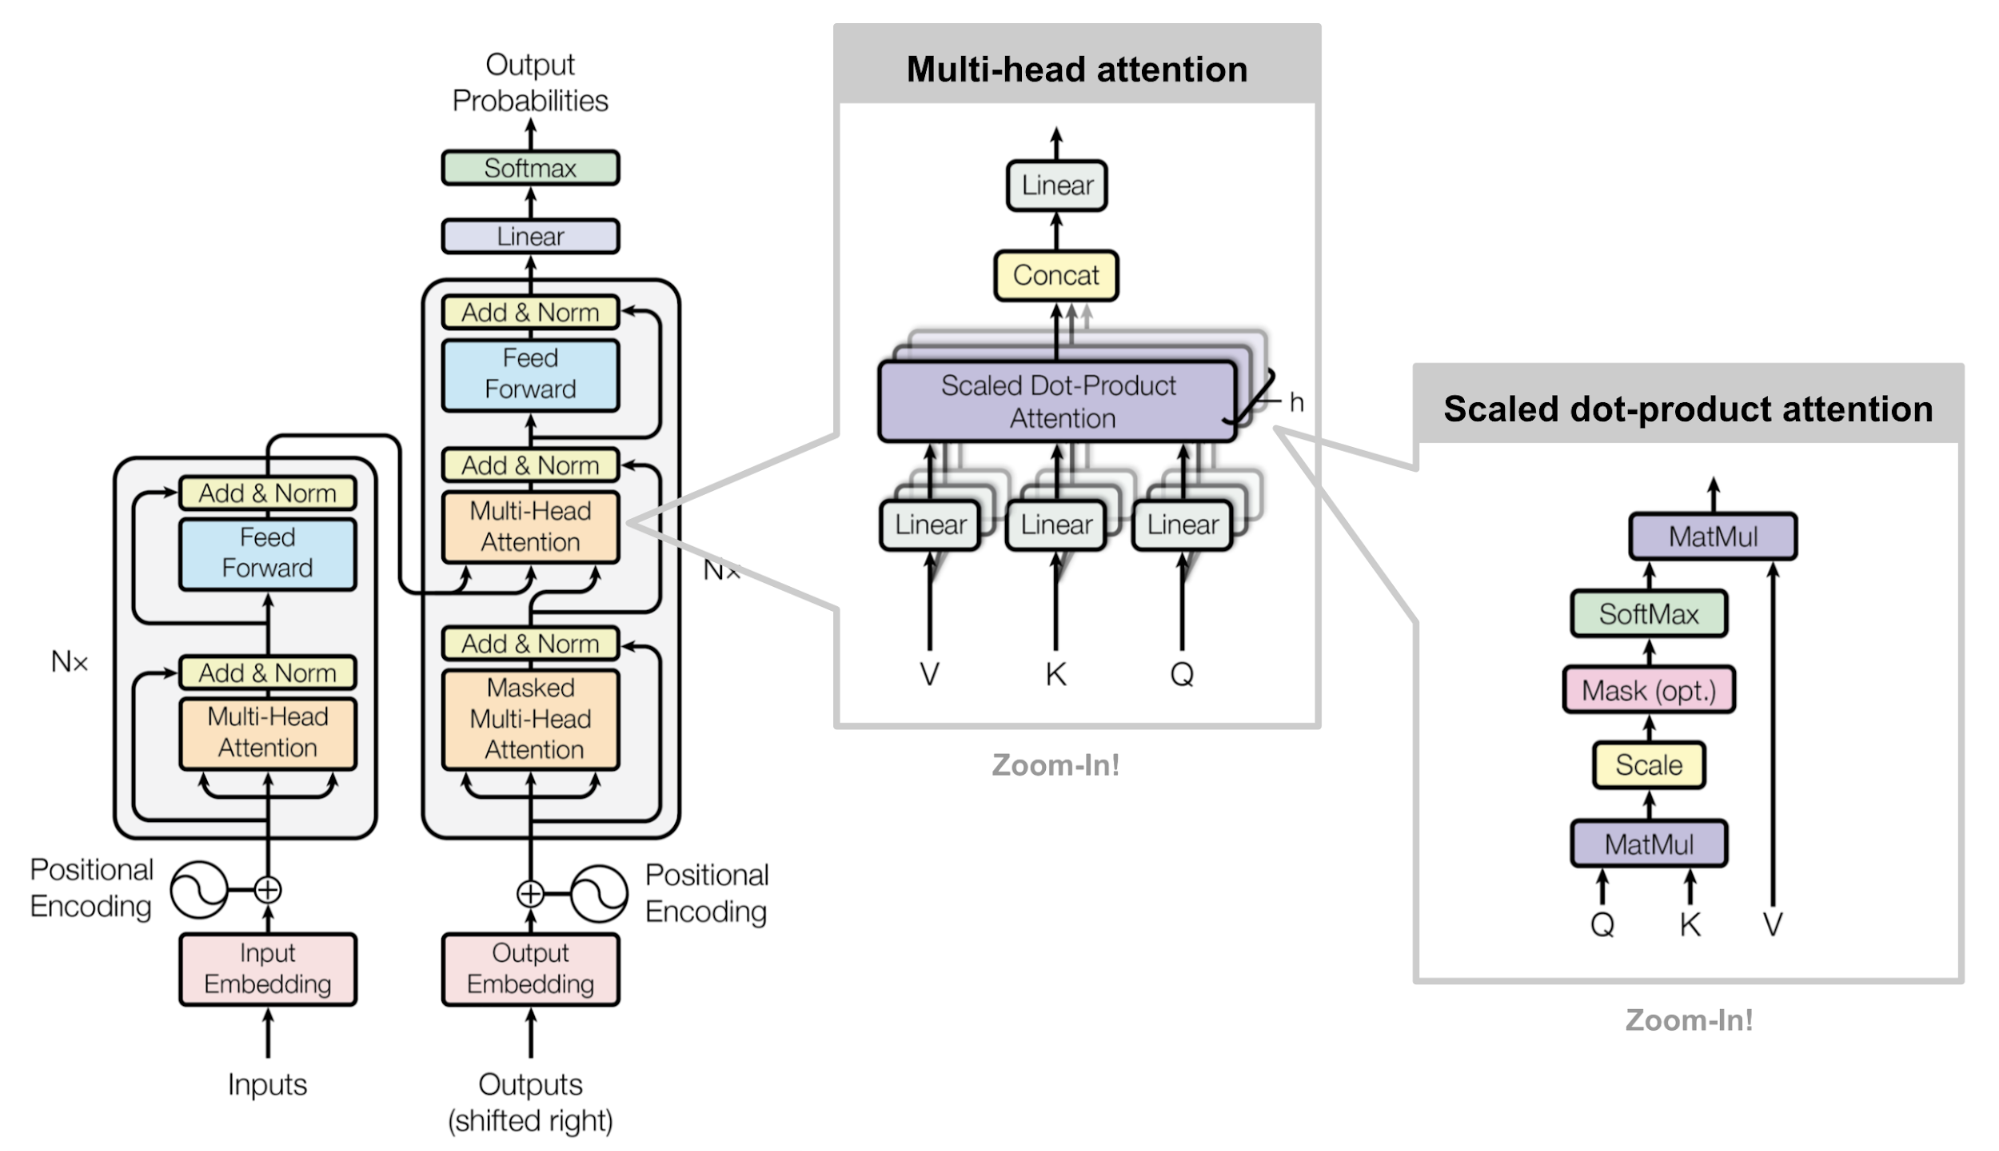

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import os

c:\Users\saulg\Anaconda3\envs\DL_PyTorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Transformer Model

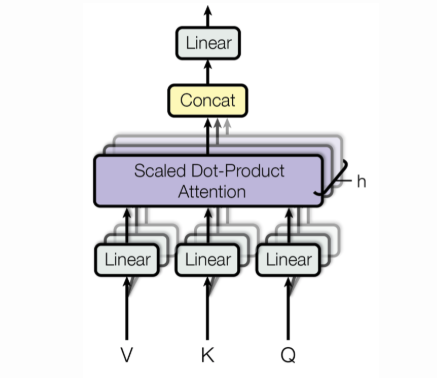
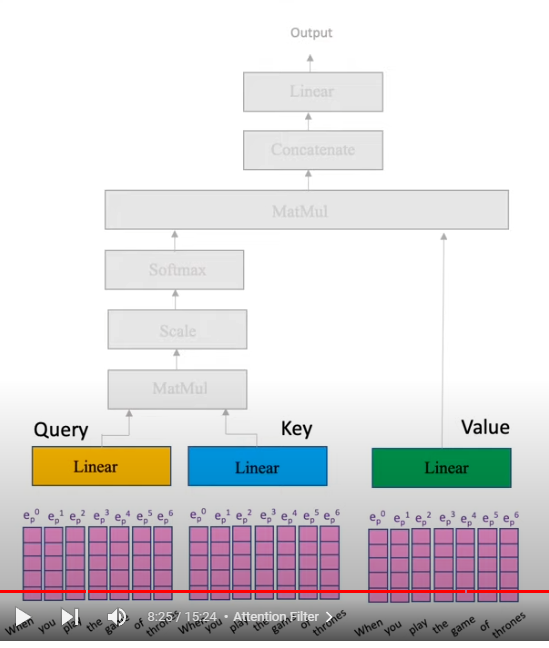
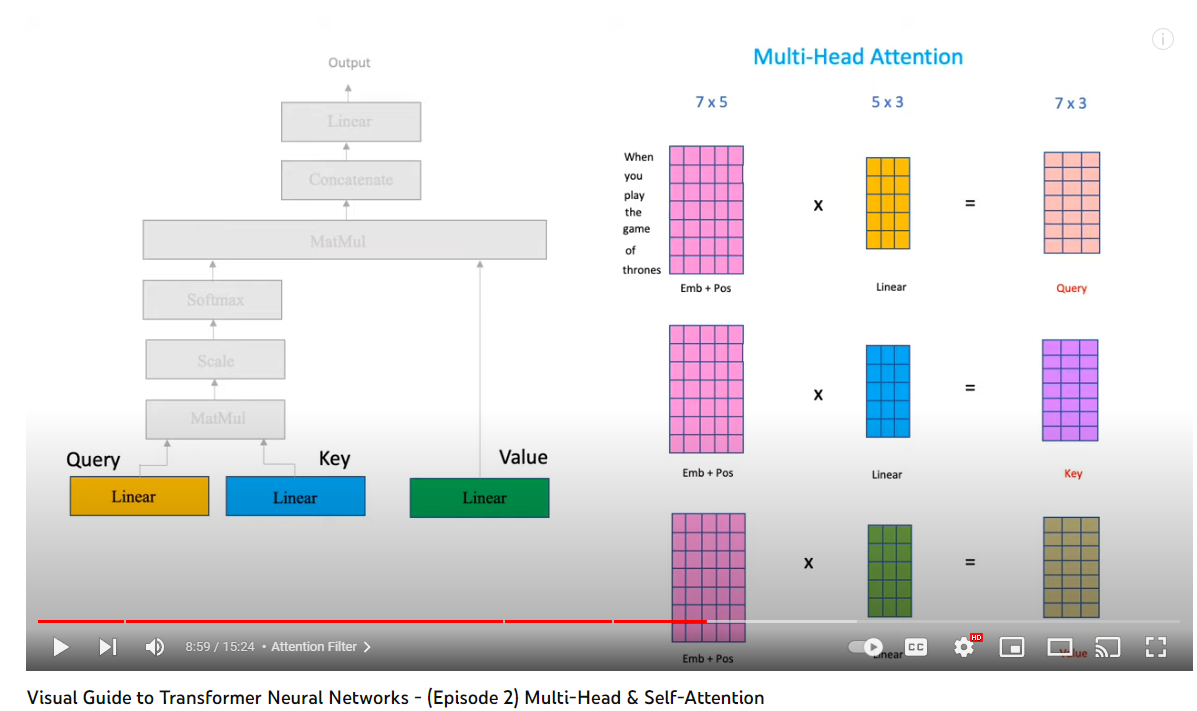

In [14]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, n_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.n_heads = n_heads
        self.head_size = embed_size // n_heads

        assert (
            self.head_size * n_heads == embed_size
        ), "Embedding size needs to be divisible by heads"
        # query: What do we want to pay attention to?
        # key: What do we want to compare our query to?
        # value: What do we want to output?
        # These are the same, so we use nn.Linear to create them
        self.query_fc = nn.Linear(embed_size, n_heads * self.head_size) # (in: 256, out: 256)
        self.keys_fc = nn.Linear(embed_size, n_heads * self.head_size)
        self.values_fc = nn.Linear(embed_size, n_heads * self.head_size)
        self.fc_out = nn.Linear(n_heads * self.head_size, embed_size) 

    def forward(self, values, keys, queries, mask):
        # Get number of training examples
        sample_size = queries.size(0)
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        #print("sample_size: ", sample_size)
        #print("values: ", values.shape)

        # passing keys into linear layer
        values = self.values_fc(values)  # (batch_size, seq_len, embed_size)
        keys = self.keys_fc(keys)  # (batch_size, seq_len, embed_size)
        queries = self.query_fc(queries)  # (batch_size, seq_len, embed_size)
        #print("values nn: ", values.shape)

        # Split the embedding into self.n_heads different pieces
        queries = queries.view(sample_size, query_len, self.n_heads, self.head_size).transpose(1, 2) # (batch_size, n_heads, seq_len, head_size)
        keys = keys.view(sample_size, key_len, self.n_heads, self.head_size).transpose(1, 2) # (batch_size, n_heads, seq_len, head_size)
        values = values.view(sample_size, value_len, self.n_heads, self.head_size).transpose(1, 2) # (batch_size, n_heads, seq_len, head_size)
        #print("values reshape: ", values.shape)

        # Calculate the energy: matrix multiplication between "query" and "keys"
        energy = torch.matmul(queries, keys.transpose(-2, -1))  # Shape: (batch_size, num_heads, seq_len, seq_len)
        #print("energy: ", energy.shape)
        # Normalize energy values basedon number of heads
        energy = energy / torch.sqrt(torch.tensor(self.head_size, dtype=torch.float32))
        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        # calculate attention weights
        attention = torch.softmax(energy, dim=3)  # Shape: (batch_size, num_heads, seq_len, seq_len)
        # Matrix multiplication with values
        attention = torch.matmul(attention, values)  # Shape: (batch_size, num_heads, seq_len, head_size)
        # Recombine heads --> (batch_size, seq_len, embed_size)
        attention = attention.transpose(1, 2).contiguous()  # Shape: (batch_size, seq_len, num_heads, head_size)
        attention = attention.view(sample_size, query_len, self.n_heads * self.head_size)
        #print("attention: ", attention.shape)
        # pass through final linear layer
        out = self.fc_out(attention)
        return out

In [18]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.n_heads = heads
        self.head_size = embed_size // self.n_heads
        assert (
            self.head_size * self.n_heads == embed_size
        ), "Embed size needs to be divisible by heads"
        # query: What do we want to pay attention to?
        # key: What do we want to compare our query to?
        # value: What do we want to output?
        # These are the same, so we use nn.Linear to create them
        self.values = nn.Linear(self.head_size, self.head_size, bias=False)
        self.keys = nn.Linear(self.head_size, self.head_size, bias=False)
        self.queries = nn.Linear(self.head_size, self.head_size, bias=False)
        self.fc_out = nn.Linear(self.n_heads * self.head_size, self.embed_size)

    def forward(self, values, keys, queries, mask):
        sample_size = queries.size(0)
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        #print(values.shape)
        
        # Split the embedding into self.heads different pieces
        values = values.reshape(sample_size, value_len, self.n_heads, self.head_size)
        keys = keys.reshape(sample_size, key_len, self.n_heads, self.head_size)
        queries = queries.reshape(sample_size, query_len, self.n_heads, self.head_size)
        #print("values reshape: ", values.shape)

        # passing keys into linear layer
        values = self.values(values)  # (N, value_len, heads, head_size)
        keys = self.keys(keys)  # (N, key_len, heads, head_size)
        queries = self.queries(queries)  # (N, query_len, heads, head_size)
        #print("values: ", values.shape)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        energy = torch.einsum("bqhd, bkhd -> bhqk", [queries, keys])
        #print("energy: ", energy.shape)
        # Normalize energy values so that they sum to 1
        energy = energy / (self.embed_size ** (1 / 2))
        
        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        # calculate attention weights
        attention = torch.softmax(energy, dim=3)
        #print("attention: ", attention.shape)
        
        out = torch.einsum("bhql, blhd -> bqhd", [attention, values]).reshape(
            sample_size, query_len, self.n_heads * self.head_size
        )
        out = self.fc_out(out)
        return out


### Transformer Body

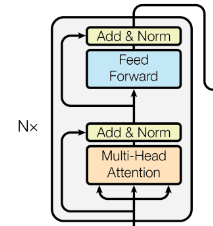

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        # forward expansion is the size of the feed forward network
        # forward expansion allows us to learn more complex functions
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        # layer norm is similar to batch norm
        # takes average and std across the embedding dimension
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        # value, key, and query shape: (N, seq_len, embed_size)
        # mask shape: (N, seq_len)
        attention = self.attention(value, key, query, mask)
        # add skip connection, residual connection
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


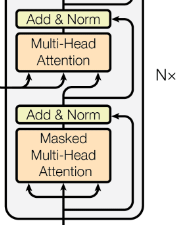

In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        # target mask is for the decoder
        # source mask is for the encoder
        # target mask pads the sequence so that the decoder can't see future tokens
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In the given example, the input dataset x has a shape of [2, 9], where 2 represents the batch size, and 9 represents the sequence length. The transformer model is then configured to have an encoding size of 256 and 8 attention heads.

When x is reshaped based on the encoding size of 256, the resulting shape becomes [2, 9, 256]. In this reshaping operation, the input sequences are expanded along the depth axis to match the specified encoding size.

In other words, for each element in the batch and sequence length, the original scalar value is replicated 256 times along the depth axis. This expansion is necessary to create a higher-dimensional representation of the input that aligns with the expected encoding size of the transformer model.

As a result, each element in the reshaped tensor [2, 9, 256] represents an encoding vector of size 256 for each token in the original input sequence.

Similarly, when the reshaped tensor [2, 9, 256] is further reshaped with 8 attention heads, the resulting shape becomes [2, 9, 8, 32]. This reshaping splits the encoding vectors into 8 separate parts or "heads," each with a size of 32. This head splitting allows the transformer model to process and attend to different aspects of the input sequence independently, facilitating parallelization and capturing diverse patterns in the data.

In summary, during reshaping, the encoding size of 256 is added as an additional depth dimension to the input, enabling the model to capture richer representations of the input sequence. The subsequent reshaping with 8 attention heads further divides these encoding vectors into smaller parts, promoting parallel processing and enhancing the model's ability to capture different aspects of the input.

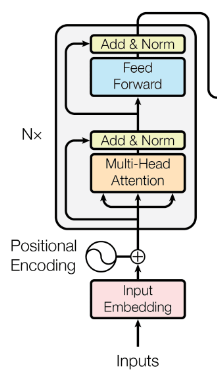

In [6]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        # how do we know vocab size?
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        # we will have num_layers of transformer blocks
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (N, seq_len)
        N, seq_len = x.shape
        # creates a tensor of positions from 0 to seq_len
        # expands the tensor to N rows and seq_len columns
        # essentially a 2d tensor size N x seq_len
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        # positions shape: (N, seq_len)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        # out shape: (N, seq_len, embed_size)
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out

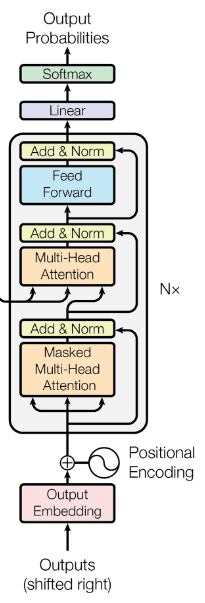

In [8]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        out = self.fc_out(x)
        return out

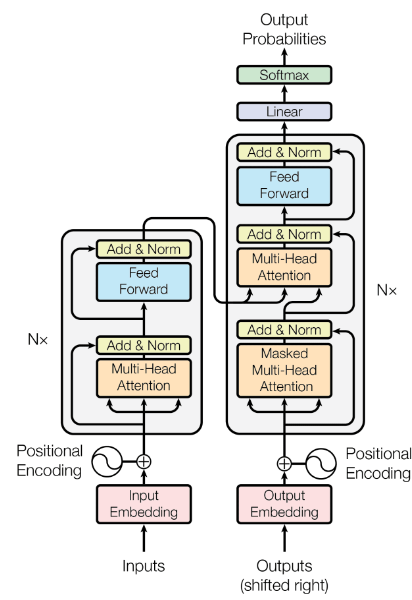

In [9]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=256,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (N, src_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        # trg_mask shape: (N, 1, trg_len, trg_len)
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # enc_src shape: (N, src_len, embed_size)
        enc_src = self.encoder(src, src_mask)
        # out shape: (N, trg_len, trg_vocab_size)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

### Example

In [19]:
# example
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
    x = torch.tensor([
        [1, 5, 6, 4, 3, 9, 5, 2, 0], 
        [1, 8, 7, 3, 4, 5, 6, 7, 2]
        ]).to(device)
    trg = torch.tensor([
        [1, 7, 4, 3, 5, 9, 2, 0], 
        [1, 5, 6, 2, 4, 7, 6, 2]
        ]).to(device)
    """
    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0]]).to(device)
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0]]).to(device)
    """
    """
    sequence_length = 4
    batch_size = 2
    input_dim = 512
    d_model = 512
    x = torch.rand((batch_size, sequence_length, input_dim)).to(device)
    """

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    
    model = Transformer(
        src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device, heads=8
    ).to(device)
    out = model(x, trg[:, :-1])
    #print(out.shape)

In [15]:
batch_size = 1
seq_len = 10
embed_size = 256
num_heads = 8

x = torch.randn(batch_size, seq_len, embed_size)
#print('input values: ', x)
print('input shape: ', x.shape)
# make array of 1s size x
mask = torch.ones((batch_size, seq_len, seq_len))
#print('mask: ', mask)
print('mask shape: ', mask.shape)

attention = MultiHeadSelfAttention(embed_size, num_heads)
output = attention(x, x, x, mask)

print('Output shape: ', output.shape)  # Output shape: (batch_size, seq_len, embed_size)
print('Output values: ', output)

input shape:  torch.Size([1, 10, 256])
mask shape:  torch.Size([1, 10, 10])
sample_size:  1
values:  torch.Size([1, 10, 256])
values nn:  torch.Size([1, 10, 256])
values reshape:  torch.Size([1, 8, 10, 32])
energy:  torch.Size([1, 8, 10, 10])
attention:  torch.Size([1, 10, 256])
Output shape:  torch.Size([1, 10, 256])
Output values:  tensor([[[ 0.1665, -0.0926, -0.0888,  ...,  0.0467, -0.2186, -0.1250],
         [ 0.1544, -0.0395, -0.1044,  ...,  0.1176, -0.1755, -0.1752],
         [ 0.1341, -0.1070, -0.1075,  ...,  0.0607, -0.1731, -0.0863],
         ...,
         [ 0.1813, -0.0244, -0.0971,  ...,  0.0647, -0.2280, -0.0165],
         [ 0.1669, -0.0356, -0.1295,  ...,  0.0882, -0.1767, -0.1786],
         [ 0.1235, -0.1169, -0.0423,  ...,  0.0820, -0.1665, -0.2004]]],
       grad_fn=<AddBackward0>)


In [16]:
#print('input values: ', x)
print('input shape: ', x.shape)

#print('mask: ', mask)
print('mask shape: ', mask.shape)

attention = SelfAttention(embed_size, num_heads)
output = attention(x, x, x, mask)

print('Output shape: ', output.shape)  # Output shape: (batch_size, seq_len, embed_size)
print('Output values: ', output)

input shape:  torch.Size([1, 10, 256])
mask shape:  torch.Size([1, 10, 10])
torch.Size([1, 10, 256])
Output shape:  torch.Size([1, 10, 256])
Output values:  tensor([[[ 0.1195, -0.0758,  0.0262,  ...,  0.0256,  0.1692,  0.0776],
         [ 0.1002, -0.0914,  0.0211,  ..., -0.0419,  0.1379,  0.0695],
         [ 0.0886, -0.1034,  0.0117,  ...,  0.0188,  0.1607,  0.0715],
         ...,
         [ 0.1118, -0.1234,  0.0290,  ...,  0.0125,  0.1705,  0.0622],
         [ 0.1463, -0.1287,  0.0548,  ...,  0.0120,  0.1882,  0.0603],
         [ 0.0957, -0.1315,  0.0225,  ...,  0.0245,  0.1609,  0.0783]]],
       grad_fn=<AddBackward0>)
